In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc
import tensorflow_probability as tfp
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, AveragePooling2D, SpatialDropout2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1, l2


2024-05-19 16:58:40.290904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 16:58:41.469086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-19 16:58:41.469129: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-19 16:58:41.602216: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 16:58:45.471581: W tensorflow/stream_executor/pla

# Asignación de GPUs

En caso de tener una GPU de Nvidia se puede utilizar para optimizar el entrenamiento, para ello debemos comprobar si esta disponible y asignarla

In [2]:


# Verifica la disponibilidad de GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs disponibles: ", len(gpus))

# Configura TensorFlow para que use la GPU si está disponible
if gpus:
    try:
        # Establece la memoria de la GPU para que crezca según sea necesario.
        # Esto puede prevenir errores de asignación de memoria en TensorFlow.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

GPUs disponibles:  1


# Carga de datos y data augmentation
Cargamos las imágenes de las carpetas train y test y aplicamos data augmentation con ImageDataGenerator. En esta parte podemos elegir la resolución de las imágenes, si queremos pasarlas a escala de grises, el batch size y las diferentes distorsiones que queramos aplicar para el aumento de datos

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Configuración del generador para entrenamiento (puedes incluir aumentación de datos aquí)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Configuración del generador para validación (usualmente sin aumentación, solo reescalado)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Creación del generador de entrenamiento
train_generator = train_datagen.flow_from_directory(
    '../images/train/', # Asegúrate de que este es el directorio correcto
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary', # o 'categorical' si tienes más de dos clases
    shuffle=True
)

# Creación del generador de validación
validation_generator = validation_datagen.flow_from_directory(
    '../images/test/',
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary', # o 'categorical'
    shuffle=True
)


#Comprobamos que se han cargado adecuadamente las etiquetas
class_indices = validation_generator.class_indices
print("Class indices:", class_indices)


Found 238 images belonging to 3 classes.
Found 31 images belonging to 3 classes.
Class indices: {'.ipynb_checkpoints': 0, '0': 1, '1': 2}


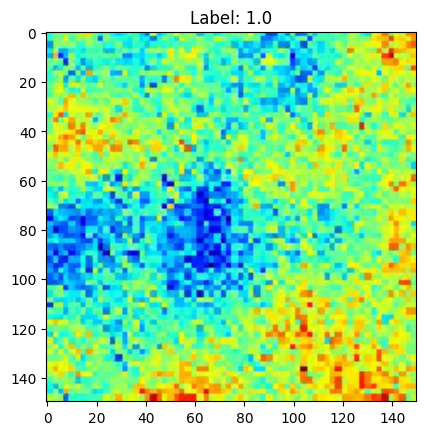

In [7]:
# Obtener el primer lote de imágenes y etiquetas
images, labels = next(validation_generator)

# Extraer la primera imagen y su etiqueta del lote
first_image = images[0]
first_label = labels[0]

# Si necesitas visualizar la imagen, puedes usar matplotlib
import matplotlib.pyplot as plt

plt.imshow(first_image)
plt.title(f'Label: {first_label}')
plt.show()

# Cálculo de métricas

Para comparar el rendimiento de los modelos con el conjunto de datos de entrenamiento se tomarán una serie de indicadores que permitirán evaluar de forma exahustiva su precisión.

In [15]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import io

class TrainingHistoryCSV(tf.keras.callbacks.Callback):
    """
    Un callback personalizado para registrar el historial de entrenamiento de un modelo en un archivo CSV.

    Atributos:
    - model_id: str, un identificador único para el modelo. Se utiliza para nombrar el archivo CSV.
    - records: list, una lista para acumular los registros de cada época.
    """
    def __init__(self, model_id):
        """
        Inicializa el callback con un identificador de modelo específico.
        
        Parámetros:
        - model_id: str, el identificador único del modelo.
        """
        super().__init__()  # Inicializa la clase base.
        self.model_id = model_id  # Almacena el identificador del modelo.
        self.records = []  # Inicializa la lista que contendrá los registros de entrenamiento.

    def on_epoch_end(self, epoch, logs=None):
        """
        Se llama al final de cada época de entrenamiento.

        Parámetros:
        - epoch: int, el número de la época que acaba de finalizar.
        - logs: dict, un diccionario con los resultados de rendimiento de la época (pérdida y métricas).
        """
        # Añade un registro para la época actual al listado de records.
        # Esto incluye el número de época, pérdida de entrenamiento, precisión de entrenamiento,
        # pérdida de validación, precisión de validación y la fecha y hora actuales.
        self.records.append([
            epoch,
            logs['loss'],
            logs['accuracy'],
            logs['val_loss'],
            logs['val_accuracy'],
            pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
        ])

    def on_train_end(self, logs=None):
        """
        Se llama al final del entrenamiento.

        Parámetros:
        - logs: dict, un diccionario con los resultados de rendimiento del último lote de entrenamiento.
        """
        # Crea un DataFrame de pandas con los registros acumulados durante el entrenamiento.
        df = pd.DataFrame(self.records, columns=['Epoch', 'Loss', 'Accuracy', 'Val_Loss', 'Val_Accuracy', 'Date'])
        
        # Guarda el DataFrame en un archivo CSV, utilizando el model_id para formar el nombre del archivo.
        # El índice no se incluye en el archivo CSV.
        df.to_csv(f'../experiments/training_data/{self.model_id}_training_data.csv', index=False)

def save_model_summary_to_txt(model, file_name):
    """
    Guarda el resumen del modelo en un archivo de texto.

    Parámetros:
    - model: Objeto modelo de Keras, el modelo del cual se guardará el resumen.
    - file_name: str, la ruta y el nombre del archivo donde se guardará el resumen.
    """
    with open(file_name, 'w') as f:
        # model.summary imprime el resumen del modelo a la consola por defecto.
        # Aquí se redirige la salida a un archivo mediante la opción print_fn.
        # Para cada línea del resumen, se añade un salto de línea al final.
        model.summary(print_fn=lambda x: f.write(x + '\n'))


def train_and_generate_csvs(model_id, model_type, model, lr, epochs):
    """
    Entrena un modelo y genera archivos CSV con el historial de entrenamiento y las métricas evaluadas.

    Parámetros:
    - model_id: str, un identificador único para el modelo.
    - model_type: str, el tipo de modelo (por ejemplo, 'CNN', 'RNN').
    - model: Objeto modelo de Keras, el modelo a entrenar.
    - lr: float, la tasa de aprendizaje para el optimizador Adam.
    - epochs: int, el número máximo de épocas para entrenar el modelo.
    """
    # Guarda el resumen del modelo en un archivo .txt utilizando el model_id para el nombre del archivo.
    save_model_summary_to_txt(model, f'../experiments/summarys/{model_id}_model_summary.txt')
    
    # Define un callback de parada temprana para detener el entrenamiento si no mejora después de 'patience' épocas.
    early_stopper = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    
    # Inicializa el callback personalizado para registrar el historial de entrenamiento en un archivo CSV.
    history_csv_callback = TrainingHistoryCSV(model_id)
    
    # Compila el modelo con el optimizador Adam, la pérdida de entropía cruzada binaria y la métrica de precisión.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Entrena el modelo utilizando tanto el generador de entrenamiento como el de validación, con los callbacks definidos.
    history = model.fit(train_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        callbacks=[early_stopper, history_csv_callback])
    
    # Calcula el número de épocas efectivamente completadas antes de la parada temprana.
    n_epochs = len(history.history['loss'])
    
    # Verifica si la parada temprana fue activada.
    early_stopping_triggered = early_stopper.stopped_epoch > 0
    




## Definición de arquitecturas de modelos

Estos son ejemplos ded arquitecturas de los diferentes modelos que se han aplicado durante el proyecto

In [9]:
def create_model_mcsd(input_shape, dropout_rate=0.5, l1_reg=0.0001, l2_reg=0.001):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, kernel_size=5, padding="VALID", activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        SpatialDropout2D(dropout_rate),
        Conv2D(64, kernel_size=5, padding="VALID", activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        SpatialDropout2D(dropout_rate),
        Conv2D(64, kernel_size=5, padding="VALID", activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation="relu", kernel_regularizer=l1(l1_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

def create_model_mcd(input_shape, dropout_rate=0.5, l1_reg=0.0001, l2_reg=0.001):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, kernel_size=5, padding="VALID", activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        Dropout(dropout_rate),
        Conv2D(128, kernel_size=5, padding="VALID", activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        Dropout(dropout_rate),
        Conv2D(128, kernel_size=5, padding="VALID", activation="relu", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        Flatten(),
        Dense(128, activation="relu", kernel_regularizer=l1(l1_reg)),
        Dropout(dropout_rate),
        Dense(64, activation="relu", kernel_regularizer=l1(l1_reg)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_model_bayes_complete_medium(input_shape,dropout_rate=0.5):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tfp.layers.Convolution2DFlipout(32, kernel_size=5, padding="SAME", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        tf.keras.layers.Dropout(dropout_rate),
        tfp.layers.Convolution2DFlipout(64, kernel_size=5, padding="SAME", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        tf.keras.layers.Dropout(dropout_rate),
        tfp.layers.Convolution2DFlipout(64, kernel_size=5, padding="VALID", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseFlipout(128, activation=tf.nn.relu),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

def create_model_bayes_conv_medium(input_shape,dropout_rate=0.5):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tfp.layers.Convolution2DFlipout(32, kernel_size=5, padding="SAME", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        tf.keras.layers.Dropout(dropout_rate),
        tfp.layers.Convolution2DFlipout(64, kernel_size=5, padding="SAME", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        tf.keras.layers.Dropout(dropout_rate),
        tfp.layers.Convolution2DFlipout(64, kernel_size=5, padding="VALID", activation=tf.nn.relu),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="VALID"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

## Entrenamiento del modeloç

In [16]:

model_id = 'test'
model_type = 'test'
lr = 0.0001
epochs =2
model = create_model_mcd((150,150,3))
train_and_generate_csvs(model_id, model_type,model,lr,epochs)
model.save(f'../models/{model_id}.h5')

Epoch 1/2
4/4 [==============================] - 51s 11s/step - loss: 7.2070 - accuracy: 0.3487 - val_loss: 7.1398 - val_accuracy: 0.0000e+00
Epoch 2/2
4/4 [==============================] - 51s 12s/step - loss: 7.2541 - accuracy: 0.3950 - val_loss: 6.6924 - val_accuracy: 0.0000e+00
